In [101]:
# Cell 1: Imports and Setup

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from torchvision.datasets import CIFAR10 # For dataset loading
import torchvision.transforms as T # Used only for download=True, manual transformation is done

# Set a random seed for reproducibility
np.random.seed(42)

In [102]:
# Cell 2: Activation and Loss Functions

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-10 # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [103]:
# Cell 3: Logistic Regression Model Class

class LogisticRegression:
    def __init__(self, input_dim, lr=0.01):
        """
        Initializes the Logistic Regression model.
        """
        self.input_dim = input_dim
        self.lr = lr
        
        # Initialize weights (W) with small random values and bias (b) with zeros
        self.W = np.random.randn(input_dim, 1) * 0.01
        self.b = np.zeros((1, 1))
        
        # History to store for plotting
        self.history = {'train_loss': [], 'train_acc': []}
        print(f"LogisticRegression model initialized with input_dim={input_dim}, lr={lr}")

    def predict_probabilities(self, X):
        """
        Calculates the output probabilities of the model.
        """
        z = X @ self.W + self.b
        a = sigmoid(z)
        return a

    def compute_gradients(self, X, y_true, y_pred):
        """
        Computes the gradients for weights and bias.
        """
        m = X.shape[0] # Number of samples in the current batch
        
        # Gradient of loss w.r.t Z (output of linear layer before sigmoid)
        dz = y_pred - y_true.reshape(-1, 1)
        
        dW = (X.T @ dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        return dW, db

    def update_params(self, dW, db):
        """
        Updates model parameters (weights and bias) using calculated gradients.
        """
        self.W -= self.lr * dW
        self.b -= self.lr * db

    def train(self, train_loader, epochs=100, print_freq=10):
        """
        Trains the logistic regression model.
        """
        print(f"\n--- Starting Training for Logistic Regression ---")
        for epoch in range(epochs):
            all_batch_loss = []
            all_batch_accuracy = []
            
            # Iterate over mini-batches
            for x_batch, y_batch in train_loader:
                # Calculate output probabilities
                y_pred = self.predict_probabilities(x_batch)
                
                # Calculate loss
                loss = binary_cross_entropy_loss(y_batch, y_pred)
                
                # Calculate gradients
                dW, db = self.compute_gradients(x_batch, y_batch, y_pred)
                
                # Update parameters
                self.update_params(dW, db)
                
                # Calculate accuracy for the current batch
                predictions = (y_pred >= 0.5).astype(int).flatten()
                accuracy = np.mean(predictions == y_batch)
                
                all_batch_loss.append(loss)
                all_batch_accuracy.append(accuracy)

            # Average loss and accuracy for the epoch
            avg_epoch_loss = np.mean(all_batch_loss)
            avg_epoch_accuracy = np.mean(all_batch_accuracy)
            
            self.history['train_loss'].append(avg_epoch_loss)
            self.history['train_acc'].append(avg_epoch_accuracy)

            if (epoch + 1) % print_freq == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f} - Acc: {avg_epoch_accuracy:.4f}")
        print(f"--- Training Finished ---")

    def predict(self, X):
        """
        Makes binary predictions based on the learned model.
        """
        return (self.predict_probabilities(X) >= 0.5).astype(int).flatten()

LogisticRegression class defined.


In [104]:
# Cell 4: Data Loading and Preprocessing

def load_and_prepare_cifar10(positive_class=0, data_dir='./data'):
    """
    Loads CIFAR-10 data, normalizes, relabels for binary classification, and flattens images.
    """
    # T.ToTensor() is primarily for PyTorch tensors; we're extracting raw data and handling normalization manually.
    transform = T.ToTensor() 

    train_set = CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    test_set = CIFAR10(root=data_dir, train=False, download=True, transform=transform)

    # Convert to NumPy arrays and normalize pixel values to [0, 1]
    x_train = train_set.data.astype(np.float32) / 255.0
    y_train = np.array(train_set.targets).flatten()
    # Relabeling: positive_class=1, others=0
    y_train_bin = (y_train == positive_class).astype(int) 

    x_test = test_set.data.astype(np.float32) / 255.0
    y_test = np.array(test_set.targets).flatten()
    # Relabeling: positive_class=1, others=0
    y_test_bin = (y_test == positive_class).astype(int) 

    # Flatten images from (N, H, W, C) to (N, H*W*C)
    x_train_flat = x_train.reshape(x_train.shape[0], -1) # (50000, 32*32*3) = (50000, 3072)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)   # (10000, 32*32*3) = (10000, 3072)

    return x_train_flat, y_train_bin, x_test_flat, y_test_bin

Data loading and preprocessing function defined.


In [105]:
# Cell 5: Simple DataLoader for Mini-Batching

class SimpleLoader:
    def __init__(self, X, y, batch_size=128, shuffle=True):
        """
        A simple DataLoader for batching and shuffling data using NumPy arrays.
        Args:
            X (np.array): Features data.
            y (np.array): Labels data.
            batch_size (int): Size of each mini-batch.
            shuffle (bool): Whether to shuffle data at the beginning of each epoch.
        """
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(X)

    def __iter__(self):
        """
        Returns an iterator for mini-batches.
        """
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices) # Shuffle indices for each epoch

        for start_idx in range(0, self.num_samples, self.batch_size):
            end_idx = min(start_idx + self.batch_size, self.num_samples)
            batch_idx = indices[start_idx:end_idx]
            
            # Directly yield NumPy arrays
            yield self.X[batch_idx], self.y[batch_idx]

SimpleLoader class defined.


In [106]:
# Cell 6: Main Execution - Data Loading and Model Training

# Load and prepare the data (airplane as positive class)
x_train, y_train, x_test, y_test = load_and_prepare_cifar10(positive_class=0, data_dir='./data')

print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Initialize and train the Logistic Regression model
input_dim = x_train.shape[1]
model = LogisticRegression(input_dim=input_dim, lr=0.0001) # Slightly lower LR for stability

# Create DataLoader for training (with mini-batching)
train_loader = SimpleLoader(x_train, y_train, batch_size=512, shuffle=True)
    
# Train the model
model.train(train_loader, epochs=25, print_freq=5)

X_train shape: (50000, 3072)
y_train shape: (50000,)
X_test shape: (10000, 3072)
y_test shape: (10000,)
LogisticRegression model initialized with input_dim=3072, lr=0.0001

--- Starting Training for Logistic Regression ---
Epoch 5/25 - Loss: 0.3434 - Acc: 0.9000
Epoch 10/25 - Loss: 0.3409 - Acc: 0.9000
Epoch 15/25 - Loss: 0.3399 - Acc: 0.9000
Epoch 20/25 - Loss: 0.3395 - Acc: 0.9000
Epoch 25/25 - Loss: 0.3391 - Acc: 0.9000
--- Training Finished ---


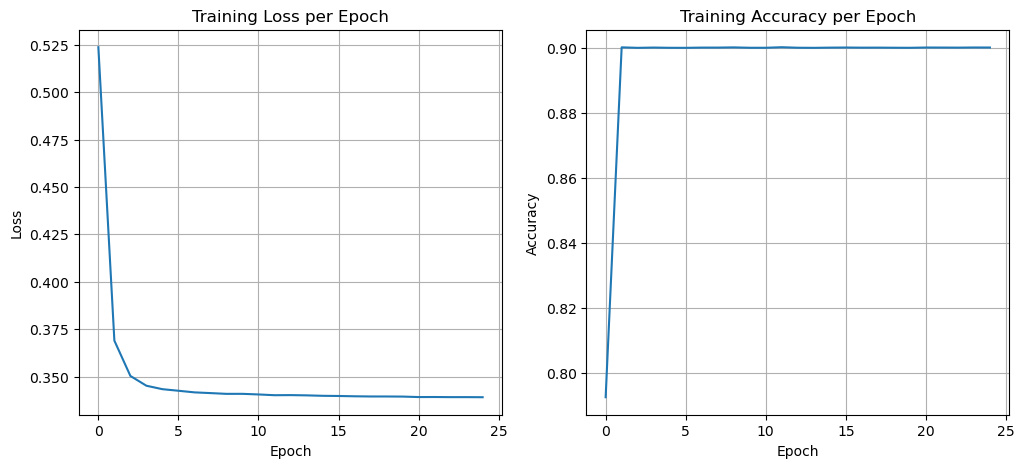

Training Loss and Accuracy plots displayed.


In [107]:
# Cell 7: Plotting Training Loss and Accuracy

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history['train_loss'])
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(model.history['train_acc'])
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print("Training Loss and Accuracy plots displayed.")

In [108]:
# Cell 8: Model Evaluation on Test Set

print("\n--- Evaluation on Test Set ---")
y_pred_test = model.predict(x_test)

# Overall Test Accuracy
test_acc = np.mean(y_pred_test == y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix with labels
cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:")
print("True Labels \\ Predicted Labels")
print("             Other   Airplane")
print(f"Other       {cm[0, 0]:<7} {cm[0, 1]:<8}")
print(f"Airplane    {cm[1, 0]:<7} {cm[1, 1]:<8}")


# F1-Score
f1 = f1_score(y_test, y_pred_test)
print(f"\nF1-Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
# target_names maps labels 0 and 1 to 'Other' and 'Airplane'
print(classification_report(y_test, y_pred_test, target_names=['Other', 'Airplane'], digits=4))

print("\nTest set evaluation complete.")


--- Evaluation on Test Set ---
Test Accuracy: 0.9000

Confusion Matrix:
True Labels \ Predicted Labels
             Other   Airplane
Other       9000    0       
Airplane    1000    0       

F1-Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

       Other     0.9000    1.0000    0.9474      9000
    Airplane     0.0000    0.0000    0.0000      1000

    accuracy                         0.9000     10000
   macro avg     0.4500    0.5000    0.4737     10000
weighted avg     0.8100    0.9000    0.8526     10000


Test set evaluation complete.


C:\Users\NAJAFI\.conda\envs\tf-gpu-py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\NAJAFI\.conda\envs\tf-gpu-py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\NAJAFI\.conda\envs\tf-gpu-py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r